In [0]:
import zipfile
zip_ref = zipfile.ZipFile('cleverhans.zip', 'r')
zip_ref.extractall()
zip_ref.close()

# **Pytorch adversarial example**


Running on GPU
CNN results without adversarial examples.


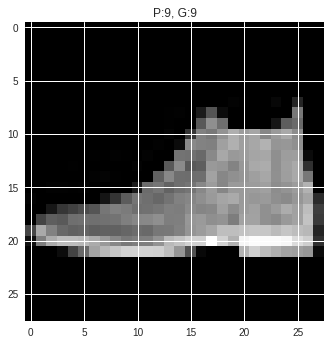

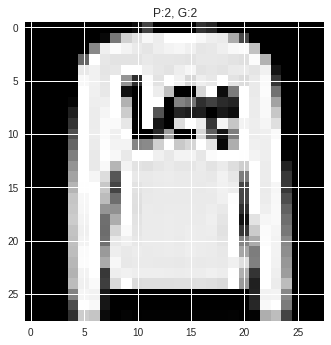

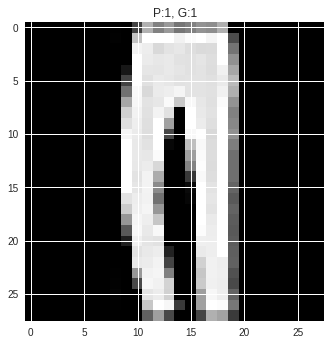

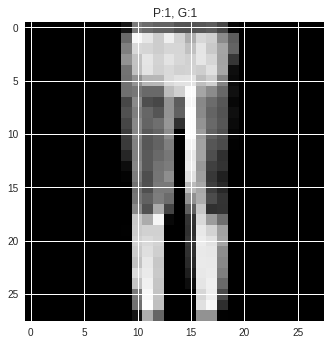

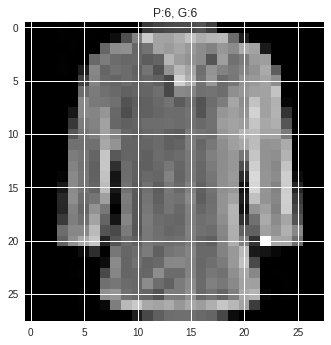

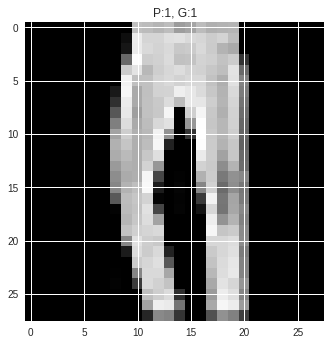

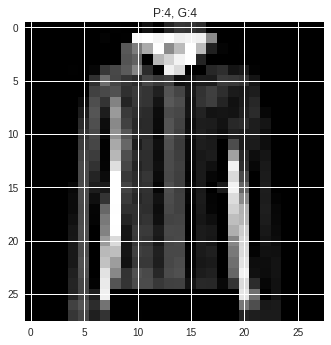

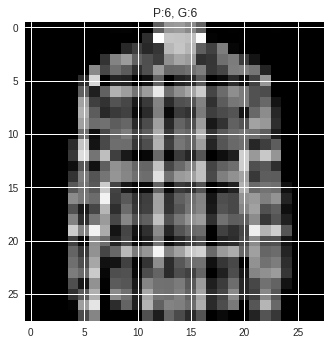

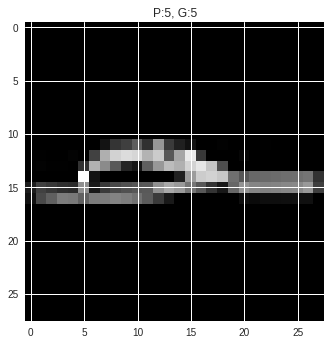

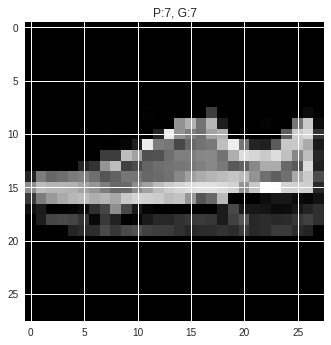

<Figure size 576x396 with 0 Axes>

In [2]:
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch import utils
import tensorflow as tf
import numpy as np

from cleverhans.attacks import FastGradientMethod
from cleverhans.compat import flags
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf


def plot_predictions(images, predicted_labels,true_labels):
    for image, predicted_label,true_label in zip(images, predicted_labels,true_labels):
        plt.imshow(image[0], 'gray')
        plt.title('P:{}, G:{}'.format(predicted_label,true_label))
        plt.show()
        plt.clf()


# basic CNN
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)


# adverserialNN
class AdverserialNN(nn.Module):
    def __init__(self,cs):
        super(AdverserialNN, self).__init__()
        self.cs = cs
        self.conv1 = nn.Conv2d(1, cs, 3, padding=1)
        self.conv2 = nn.Conv2d(cs, cs, 3, padding=1)
        self.fc1 = nn.Linear(cs * 7 * 7, 784)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.cs * 7 * 7)
        x = self.fc1(x)

        x = x.view(-1, 1, 28, 28)

        return x

gpu = torch.cuda.is_available()
if gpu:
    print('Running on GPU')
else:
    print('Running on CPU')

# load using datasets loader from torchvision
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=16)

model = ConvNN()

if gpu:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train the CNN
for idx, (xs, ys) in enumerate(train_loader):
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    
    
    optimizer.zero_grad()
    preds = model(xs)
    loss = F.nll_loss(preds, ys)
    loss.backward()
    optimizer.step()

    if idx >= 10000:
        print(preds[0].argmax(), ys[0], loss.item())

# get test images
test_set = next(iter(test_loader))
test_images = test_set[0]
test_labels = test_set[1]

if gpu:
    test_images = test_images.cuda()
    test_labels = test_labels.cuda()

# predict with untouched test images
predicted_labels = model(test_images).argmax(dim=1).cpu().detach().numpy()
print('CNN results without adversarial examples.')
plot_predictions(test_images[0:10].cpu().detach().numpy(), predicted_labels[0:10],test_labels[0:10].cpu().detach().numpy())

adverserial_epochs = 100000
info_range = 2957 # a random number so we see a different object everytime

# **Use Selfmade Adverserial Model**

CNN results with custom adversarial examples.


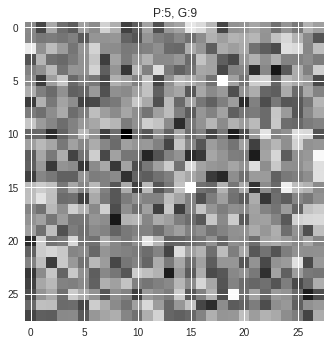

CNN Loss:2.0, Closeness:9.07158374786377 Adverserial Loss:7.0715837478637695


In [0]:
channel_size = 128
adverserial_model = AdverserialNN(channel_size)
adverserial_model.cuda()
optimizer = torch.optim.Adam(adverserial_model.parameters(), lr=0.0001)

# fix the CNN, train adverserialNN to make the test_images look as close to their original as possible, while still misclassifiying
min_clip = 2
max_clip = 0

print('CNN results with custom adversarial examples.')
for idx in range(adverserial_epochs):
    current_batch = idx % len(test_images)
    optimizer.zero_grad()
    output_images = adverserial_model(test_images[current_batch:current_batch+1])
    preds = model(output_images)
    min_torch = torch.FloatTensor([min_clip])
    max_torch = torch.FloatTensor([max_clip])
    if gpu:
        min_torch = min_torch.cuda()
        max_torch = max_torch.cuda()

    classifier_loss = torch.min(min_torch,F.cross_entropy(preds, test_labels[current_batch:current_batch+1]))
    #if it is closer than 10, it is perfect
    closeness = torch.max(max_torch,torch.norm(test_images[current_batch:current_batch+1] - output_images))
    adverserial_loss = -classifier_loss + closeness

    adverserial_loss.backward()
    optimizer.step()
    if idx % info_range == 0:
        plot_predictions(output_images[:1].cpu().detach().numpy(), preds[:1].argmax(dim=1).cpu().detach().numpy(),test_labels[current_batch:current_batch+1].cpu().detach().numpy() )
        print('CNN Loss:{}, Closeness:{} Adverserial Loss:{}'.format(classifier_loss.item(), closeness.item(), adverserial_loss.item()))


# **Use Cleverhans Adverserial Model**

In [0]:
  # We use tf for evaluation on adversarial data
  sess = tf.Session()
  x_op = tf.placeholder(tf.float32, shape=(None, 1, 28, 28,))

  # Convert pytorch model to a tf_model and wrap it in cleverhans
  tf_model_fn = convert_pytorch_model_to_tf(model)
  cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')

  # Create an FGSM attack
  fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
  fgsm_params = {'eps': 0.025,
                 'clip_min': 0.,
                 'clip_max': 1.}
  adv_x_op = fgsm_op.generate(x_op, **fgsm_params)
  adv_preds_op = tf_model_fn(adv_x_op)

  # Run an evaluation of our model against fgsm
  total = 0
  correct = 0
  
  print('CNN results with cleverhans adversarial examples.')
  for idx in range(adverserial_epochs):
      current_batch = idx % len(test_images)
      avd_images = sess.run(adv_x_op,feed_dict={x_op:test_images[current_batch:current_batch+1].cpu()})
      adv_preds = sess.run(adv_preds_op, feed_dict={x_op: test_images[current_batch:current_batch+1].cpu()})
      correct += (np.argmax(adv_preds, axis=1) == test_labels[current_batch:current_batch+1].cpu().detach().numpy()).sum()
      total += 1
      if idx % info_range == 0:
          plot_predictions(avd_images[0:8], adv_preds[:8].argmax(axis=1),test_labels[:8].cpu().detach().numpy())
          acc = float(correct) / total
          print('Adv accuracy: {:.3f}'.format(acc * 100))

  acc = float(correct) / total
  print('Adv accuracy: {:.3f}'.format(acc * 100))
